# Replication Notebook
This notebook is meant to replicate the results of the paper. Run the following 3 cells to replicate the results. A detailed version of how the code is written is in a seperate notebook.

In [2]:
import itertools
import sklearn
import pandas as pd
import json
import numpy as np
import ast
from tqdm.auto import tqdm
import statistics
import math
import csv
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import NearestCentroid
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
from sklearn.calibration import calibration_curve
from copy import deepcopy
import pprint
import ast
import statistics
import math
import time
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    mean_squared_error,
    r2_score,
    roc_auc_score,
    average_precision_score,
)
import matplotlib.pyplot as plt
from nltk import agreement
import scipy.stats as stats
import seaborn as sns
np.random.seed(1)

/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Methods
The following cell will load all the data, process, and analyze for replication purposes. The results will be printed in the following cell. This will take a couple of minutes to run.

In [10]:
embedding_path = '../data/raw/df_embeddings.csv'
submission_path = '../data/raw/df_submission_rating.csv'


df_embeddings = pd.read_csv(embedding_path)
df_embeddings = df_embeddings.T
df_embeddings.columns=df_embeddings.iloc[0]
df_embeddings = df_embeddings.iloc[1: , :]


tqdm.pandas()
def get_numpy (row):
  return ast.literal_eval(row.embedding)

df_embeddings['embedding'] = df_embeddings.apply(lambda x: get_numpy(x), axis =1)

df_submissions = pd.read_csv(submission_path)
df_submission_labels = df_submissions[['id','title','conf_year','keywords','AVG_rating']]

df_embeddings_2017 = df_embeddings.merge(df_submission_labels[df_submission_labels['conf_year']==2017], left_on='paper_id',right_on='id')
df_embeddings_2018 = df_embeddings.merge(df_submission_labels[df_submission_labels['conf_year']==2018], left_on='paper_id',right_on='id')
assert df_submission_labels[df_submission_labels['conf_year']==2017].shape[0] == df_embeddings_2017.shape[0]

#Section 3.3 Step 2 agglomerative clustering on cosine distance
x = np.array(df_embeddings_2017.embedding.tolist())
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=0.1, linkage="average", metric = 'cosine').fit(x)
df_embeddings_2017['agg_cluster'] = clustering.labels_.tolist()
x = np.array(df_embeddings_2017.embedding.tolist())
y = np.array(df_embeddings_2017.agg_cluster.tolist())
clf = NearestCentroid()
clf.fit(x, y)

assert df_embeddings_2018.shape[0] == df_submission_labels[df_submission_labels['conf_year']==2018].shape[0]

#Section 3.3. Step 3

#setting up KNN for 2018
neigh = NearestNeighbors( n_neighbors=10, metric = 'cosine', radius = 0.3)
non_anchor_embedding_2018 = np.array(df_embeddings_2018.embedding.to_list())
neigh.fit(non_anchor_embedding_2018)

#setting up closest centroid for anchor group 2017
anchor_embedding_2017 = np.array(df_embeddings_2017.embedding.tolist())
anchor_agg_clusters_2017 = np.array(df_embeddings_2017.agg_cluster.tolist())
clf = NearestCentroid()
clf.fit(anchor_embedding_2017, anchor_agg_clusters_2017)



#dictionary of all the agg clusters and the 10 KNN from 2018
dict_agg_cluster_matches ={}
tuning_param_cos_dist = 0.3
for cluster_id in np.unique(clustering.labels_):
    
    distances, indices = neigh.kneighbors([clf.centroids_[cluster_id]])
    df_anchor_embedding = pd.concat([pd.DataFrame(data = distances.T,columns =['cos_dist']),pd.DataFrame(indices.T,columns=['indices'])],axis=1)

    #get all the specified cosine distance 2018 papers
    #tuple of (dataframe of 2018 matched papers, cosine distances)
    dict_agg_cluster_matches[cluster_id] = (
        df_embeddings_2018.iloc[df_anchor_embedding[df_anchor_embedding['cos_dist']<= tuning_param_cos_dist].indices.to_list(), :],
        df_anchor_embedding[df_anchor_embedding['cos_dist']<= tuning_param_cos_dist].cos_dist.to_list()
    )


def lambda_get_2018_matches(row):
    #get embedding matches from 2018 papers
    #returning relevant information
    df_clustered_papers = dict_agg_cluster_matches[row.agg_cluster]
    
    lst_paper_titles = df_clustered_papers[0].title.tolist()
    lst_paper_ids = df_clustered_papers[0].paper_id.tolist()
    ls_paper_keywords = df_clustered_papers[0].keywords.values.tolist()
    ls_cos_distances = df_clustered_papers[1]
    
    return lst_paper_titles, ls_paper_keywords, lst_paper_ids, ls_cos_distances

df_embeddings_2017[['titles_2018','keywords_2018','id_2018','cos_dist_2018']]= df_embeddings_2017.apply(lambda x: lambda_get_2018_matches(x),axis=1, result_type ='expand')
df_cos_dist_sample = pd.concat([df_embeddings_2017[['agg_cluster']],pd.DataFrame(df_embeddings_2017["cos_dist_2018"].to_list())], axis=1)

#tuning charts
#get the max number of samples with the lowest possible cosine distance
df_tuning = df_cos_dist_sample.drop(['agg_cluster'],axis = 1)

data = []
for tuning_param_cos_dist in np.linspace(0,0.3 ,1000):
    input_row = {}
    sample_number_from_2017 = df_tuning[df_tuning<=tuning_param_cos_dist].any(axis=1).sum()
    
    input_row['sample_number_2017'] = sample_number_from_2017
    input_row['cosine_distance'] = tuning_param_cos_dist
    if sample_number_from_2017 == df_tuning.shape[0]:
        input_row['full_sample_flag'] = 'Full Sample'
    else:
        input_row['full_sample_flag'] = 'Partial Sample'
    data.append(input_row)


x = pd.DataFrame(data)

#Tune KNN matching based on smallest possible cosine distance

tuning_param_knn = 10
tuning_param_cos_dist = 0.234535

neigh = NearestNeighbors( n_neighbors=tuning_param_knn, metric = 'cosine', radius = 0.3)
non_anchor_embedding_2018 = np.array(df_embeddings_2018.embedding.to_list())
neigh.fit(non_anchor_embedding_2018)

#setting up closest centroid for anchor group 2017
anchor_embedding_2017 = np.array(df_embeddings_2017.embedding.tolist())
anchor_agg_clusters_2017 = np.array(df_embeddings_2017.agg_cluster.tolist())
clf = NearestCentroid()
clf.fit(anchor_embedding_2017, anchor_agg_clusters_2017)


#dictionary of all the agg clusters and the 20 KNN from 2018
dict_agg_cluster_matches ={}
for cluster_id in np.unique(clustering.labels_):
    
    distances, indices = neigh.kneighbors([clf.centroids_[cluster_id]])
    df_anchor_embedding = pd.concat([pd.DataFrame(data = distances.T,columns =['cos_dist']),pd.DataFrame(indices.T,columns=['indices'])],axis=1)

    #get all the specified cosine distance 2018 papers
    #tuple of (dataframe of 2018 matched papers, cosine distances)
    dict_agg_cluster_matches[cluster_id] = (
        df_embeddings_2018.iloc[df_anchor_embedding[df_anchor_embedding['cos_dist']<= tuning_param_cos_dist].indices.to_list(), :],
        df_anchor_embedding[df_anchor_embedding['cos_dist']<= tuning_param_cos_dist].cos_dist.to_list()
    )

def lambda_get_2018_matches(row):
    #get embedding matches from 2018 papers
    #returning relevant information
    df_clustered_papers = dict_agg_cluster_matches[row.agg_cluster]
    
    lst_paper_titles = df_clustered_papers[0].title.tolist()
    lst_paper_ids = df_clustered_papers[0].paper_id.tolist()
    ls_paper_keywords = df_clustered_papers[0].keywords.values.tolist()
    ls_cos_distances = df_clustered_papers[1]
    
    return lst_paper_titles, ls_paper_keywords, lst_paper_ids, ls_cos_distances
    
    
    

df_embeddings_2017[['titles_2018','keywords_2018','id_2018','cos_dist_2018']]= df_embeddings_2017.apply(lambda x: lambda_get_2018_matches(x),axis=1, result_type ='expand')

def get_num_knn_matches(row):
    count = len(row.titles_2018)
    return(len(row.titles_2018))

df_embeddings_2017['num_knn_matches'] = df_embeddings_2017.apply(lambda x: get_num_knn_matches(x),axis =1)

assert df_embeddings_2017.shape[0] == df_submission_labels[df_submission_labels['conf_year']==2017].shape[0]

#Matching potential outcome estimator
#Keith et al. 2020
#https://aclanthology.org/2020.acl-main.474.pdf
#equation 7 and 8

def lambda_get_match_potential_outcomes(row):
    #equation 7 in the paper
    paper_ids = row.id_2018
    big_m = len(row.id_2018)
    if big_m == 0:
        return None
    ratings = [df_embeddings_2018[df_embeddings_2018['paper_id'] == paper_id].AVG_rating.values[0] for paper_id in paper_ids]
    return sum(ratings)/big_m
        
    

df_embeddings_2017['match_ave_rating'] = df_embeddings_2017.apply(lambda row: lambda_get_match_potential_outcomes(row), axis =1)
df_embeddings_2017['diff_2018_2017'] = df_embeddings_2017['match_ave_rating'] - df_embeddings_2017['AVG_rating']

df_embeddings_2017 = df_embeddings_2017.loc[df_embeddings_2017['match_ave_rating'].notnull(),]

#equation 8 in the paper
KNN_ATT = (df_embeddings_2017['match_ave_rating'] - df_embeddings_2017['AVG_rating']).sum()/df_embeddings_2017.shape[0]

assert df_embeddings_2017['match_ave_rating'].shape[0] == df_embeddings_2017['AVG_rating'].shape[0]

#bootstrap KNN confidence interval
bootstrap_mean = []
for n in range(5000):
    sample = df_embeddings_2017.diff_2018_2017.sample(n=df_embeddings_2017.shape[0], replace = True ,random_state=n)
    bootstrap_mean.append(sample.mean())

#report mean of the empirical sample
mean = df_embeddings_2017.diff_2018_2017.mean() #statistics.mean(bootstrap_mean)
CI_lower_bound_knn = np.quantile(bootstrap_mean, 0.025)
CI_upper_bound_knn = np.quantile(bootstrap_mean, 0.975)
CI_knn_range = abs(CI_lower_bound_knn) -abs(CI_upper_bound_knn)

#Bootstrap of Naive Difference in Means Estimator
bootstrap_naive_mean = []

for n in range(5000):
    sample_2017 = df_embeddings_2017.AVG_rating.sample(n=df_embeddings_2017.shape[0], replace = True ,random_state=n)
    sample_2018 = df_embeddings_2018.AVG_rating.sample(n=df_embeddings_2018.shape[0], replace = True ,random_state=n)
    
    sample_diff = sample_2018.mean() - sample_2017.mean()
    
    bootstrap_naive_mean.append(sample_diff)

naive_mean = df_embeddings_2018.AVG_rating.mean() - df_embeddings_2017.AVG_rating.mean()
CI_lower_bound_naive = np.quantile(bootstrap_naive_mean, 0.025)
CI_upper_bound_naive = np.quantile(bootstrap_naive_mean, 0.975)
CI_naive_range = abs(CI_lower_bound_naive) -abs(CI_upper_bound_naive)


#propensity score matching
df_embeddings = pd.read_csv(embedding_path)
df_embeddings = df_embeddings.T
df_embeddings.columns=df_embeddings.iloc[0]
df_embeddings = df_embeddings.iloc[1: , :]


def get_numpy (row):
  return ast.literal_eval(row.embedding)

df_embeddings['embedding'] = df_embeddings.apply(lambda x: get_numpy(x), axis =1)
df_submissions = pd.read_csv(submission_path)
df_submission_labels = df_submissions[['id','title','conf_year','keywords','AVG_rating']]
df_embeddings = df_embeddings.merge(df_submission_labels[df_submission_labels['conf_year'].isin([2017,2018])], left_on='paper_id',right_on='id')
df_embeddings['treatment'] = df_embeddings['conf_year'].replace([2017,2018],[1,0])

np_embeddings =np.array([np.array(embedding) for embedding in df_embeddings.embedding.to_list()])
paper_id = np.array(df_embeddings.id.to_list())
treatment_id = np.array(df_embeddings.treatment.to_list())

if np_embeddings.shape[0] == treatment_id.shape[0] == df_embeddings.shape[0] == paper_id.shape[0]:
    
    E= np_embeddings
    T = treatment_id
    n_total = df_embeddings.shape[0]
    docids = paper_id
    
    if E.shape[0] == T.shape[0] == n_total == docids.shape[0]:
        print('pass')
    else:
        print('error')
    
else:
    print('error')
    
NUM_CROSSFIT_SPLITS = 2
NUM_CROSSVAL_SPLITS = 4 
RANDOM_STATE = 42 #for replication 

CLASSIFIER = Pipeline([(
            "model",
            LogisticRegression(
                l1_ratio=0.1,
                solver="saga",
                max_iter=20000,
                tol=1e-3, 
                penalty="elasticnet",
                dual=False,
                class_weight="balanced",
                random_state=42,
                ),),])

CLASSIFIER_GRID = {
    "model__C": [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1],
}

#Note: May take awhile to run
prob_t_training = np.array([np.nan]*n_total) #only for reporting training acc numbers 
prob_t_inference = np.array([np.nan]*n_total) #array to save predicted propensity scores 
# Crossfitting 

start = time.time()

crossfit_split = list(StratifiedKFold(n_splits=NUM_CROSSFIT_SPLITS, shuffle=True, random_state=RANDOM_STATE).split(E, T))
for crossfit_number, (train_inds, test_inds) in enumerate(crossfit_split):
    #print('Crossfit num=', crossfit_number)
    # Training 
    # Cross validation for the training split 
    inner_cv = StratifiedShuffleSplit(
                n_splits=NUM_CROSSVAL_SPLITS,
                test_size=1/NUM_CROSSVAL_SPLITS,
                random_state= RANDOM_STATE,
            )
    
    t_model_gridsearch = GridSearchCV(
                        estimator=deepcopy(CLASSIFIER),
                        param_grid=deepcopy(CLASSIFIER_GRID),
                        cv=inner_cv,
                        scoring="roc_auc",
                        refit=True,
                    )
    
    t_model_gridsearch.fit(E[train_inds], T[train_inds])
    prob_t_training[train_inds] = t_model_gridsearch.predict_proba(E[train_inds])[:, 1]
        
    # Inference
    # Probability of T=1
    prop_t = t_model_gridsearch.predict_proba(E[test_inds])[:, 1]
    prob_t_inference[test_inds] = prop_t

end = time.time()

#Subtract Start Time from The End Time
total_time = end - start
assert np.mean(np.isnan(prob_t_training)) == 0.0
assert np.mean(np.isnan(prob_t_inference)) == 0.0
# Training metrics 
pred_model_report_out = {}

def mean_predictions(dummy, y_pred):
    """
    Helpful for error diagnosing. Returns the mean of the predcted values
    Args:
        - dummy : we need this arg so that this function looks the same as
        sklearn error metrics that take inputs y_true, y_pred
        - y_pred : np.array
    """
    return np.mean(y_pred)

def calibration_rmse(y_true, y_pred): 
    """
    Calculates calibration root mean squared error (RMSE). 
    Calibration is the extent to which a model's probabilistic predictions match their 
    corresponding empirical frequencies. 
    See Nguyen and O'Connor 2015's introduction and definitions 
    https://www.emnlp2015.org/proceedings/EMNLP/pdf/EMNLP182.pdf
    """
    prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=10, strategy='uniform')
    rms = mean_squared_error(prob_true, prob_pred, squared=False) #False returns RMSE vs MSE 
    return rms


def mean_truth(y_true, dummy):
    """
    Helpful for error diagnosing. Returns the mean of the true values
    Args:
        - y_true : np.array
        - dummy : we need this arg so that this function looks the same as
        sklearn error metrics that take inputs y_true, y_pred
    """
    return np.mean(y_true)

# these classification metrics need the "hard" predictions, e.g. y=[0, 0, 1, ...]
class_hard_name2metric_func = {
    "f1": f1_score,
    "acc": accuracy_score,
    "mean_hard_pred": mean_predictions,
    "mean_true": mean_truth,  # should be same for hard or soft
}

# these classification metrics need the "score" predictions, e.g. y=[0.6, 0.77, 0.2, ...]
class_scores_name2metric_func = {
    "roc_auc": roc_auc_score,
    "ave_prec": average_precision_score,
    "calibration_rmse": calibration_rmse,
    "mean_soft_pred": mean_predictions,
    "mean_true": mean_truth,  # should be same for hard or soft
}

#hard classifications
t_pred_hard = (prob_t_training > 0.5).astype(int)

assert t_pred_hard.shape == prob_t_training.shape == T.shape

str_sep = "--"
for metric_str, metric_func in class_hard_name2metric_func.items():
    pred_model_report_out["treatment_model" + str_sep + metric_str] = metric_func(T, t_pred_hard)
for metric_str, metric_func in class_scores_name2metric_func.items():
    pred_model_report_out["treatment_model" + str_sep + metric_str] = metric_func(T, prob_t_training)

NUM_STRATA = 5 
def get_strata(prob_t_score, num_strata): 
    """
    Reports the strata given the probability score 
    
    Strata index starts at 1 
    """
    strata = np.arange(0, 1.0, 1.0/num_strata)
    return np.digitize(prob_t_score, strata, right=False)
docid2strata = {}
for docid, prob_t_score in zip(docids, prob_t_inference): 
    strata_inferred = get_strata(prob_t_score, NUM_STRATA)
    docid2strata[docid] = (strata_inferred, prob_t_score)
data = []
for x in docid2strata.items():
    input_row = {}
    input_row['paperID'] = x[0]
    input_row['strata'] = x[1][0]
    input_row['pscore'] = x[1][1]
    data.append(input_row)




df_paper_strata = df_embeddings.merge(pd.DataFrame(data), left_on='paper_id',right_on='paperID')[['paper_id','title','strata','keywords','pscore','treatment','AVG_rating','conf_year']]

def strip_char(row):
    word_list = ast.literal_eval(row.keywords)
    s = ''
    for word in word_list:
        s += " " + word.replace(' ','_').replace('-','_').lower()
    return s

df_paper_strata['transformed_keywords'] = df_paper_strata.apply(lambda x: strip_char(x), axis = 1)



boostrap_SPSM = []
for n in range(5001):
    sample = df_paper_strata[df_paper_strata['treatment'] ==1].sample(n=490, replace = True ,random_state=n)

    strata_2_weight = sample[(sample['strata'] ==2) & (sample['treatment'] ==1)].shape[0]/490

    strata_3_weight = sample[(sample['strata'] ==3) & (sample['treatment'] ==1)].shape[0]/490

    strata_4_weight = sample[(sample['strata'] ==4) & (sample['treatment'] ==1)].shape[0]/490

    strat_2_treated = sample[(sample['strata'] ==2) & (sample['treatment'] ==1)]['AVG_rating'].mean()
    strat_2_control = df_paper_strata[(df_paper_strata['strata'] ==2) & (df_paper_strata['treatment'] ==0)]['AVG_rating'].mean()
    
    
    strat_3_treated = sample[(sample['strata'] ==3) & (sample['treatment'] ==1)]['AVG_rating'].mean()
    strat_3_control = df_paper_strata[(df_paper_strata['strata'] ==3) & (df_paper_strata['treatment'] ==0)]['AVG_rating'].mean()
    
    strat_4_treated = sample[(sample['strata'] ==4) & (sample['treatment'] ==1)]['AVG_rating'].mean()
    strat_4_control = df_paper_strata[(df_paper_strata['strata'] ==4) & (df_paper_strata['treatment'] ==0)]['AVG_rating'].mean()

    

    ATT = (strat_4_treated - strat_4_control)* strata_4_weight + (strat_3_treated - strat_3_control)* strata_3_weight + (strat_2_treated - strat_2_control)* strata_2_weight
    boostrap_SPSM.append(ATT)


#SPSM ATT calcuation
sample = df_paper_strata[df_paper_strata['treatment'] ==1]
strata_2_weight = sample[(sample['strata'] ==2) & (sample['treatment'] ==1)].shape[0]/490
strata_3_weight = sample[(sample['strata'] ==3) & (sample['treatment'] ==1)].shape[0]/490
strata_4_weight = sample[(sample['strata'] ==4) & (sample['treatment'] ==1)].shape[0]/490
strat_2_treated = sample[(sample['strata'] ==2) & (sample['treatment'] ==1)]['AVG_rating'].mean()
strat_2_control = df_paper_strata[(df_paper_strata['strata'] ==2) & (df_paper_strata['treatment'] ==0)]['AVG_rating'].mean()
strat_3_treated = sample[(sample['strata'] ==3) & (sample['treatment'] ==1)]['AVG_rating'].mean()
strat_3_control = df_paper_strata[(df_paper_strata['strata'] ==3) & (df_paper_strata['treatment'] ==0)]['AVG_rating'].mean()
strat_4_treated = sample[(sample['strata'] ==4) & (sample['treatment'] ==1)]['AVG_rating'].mean()
strat_4_control = df_paper_strata[(df_paper_strata['strata'] ==4) & (df_paper_strata['treatment'] ==0)]['AVG_rating'].mean()
SPSM_mean = (strat_4_treated - strat_4_control)* strata_4_weight + (strat_3_treated - strat_3_control)* strata_3_weight + (strat_2_treated - strat_2_control)* strata_2_weight    

#checking for evaulation results
df_labeled = pd.read_csv('../data/evaulation_data/evaluation_set_with_labels_DONT_LOOK.csv')
df_rz = pd.read_csv('../data/evaulation_data/Title_Evaluation_Final_RZ.csv')
df_kk = pd.read_csv('../data/evaulation_data/Title_Evaluation_Final_KK.csv')
df_nk = pd.read_csv('../data/evaulation_data/Title_Evaluation_Final_NK.csv')
df_rz_rating = df_rz[['unique_id','Rating']]
df_kk_rating = df_kk[['unique_id','Rating']]
df_nk_rating = df_nk[['unique_id','Rating']]
df_rz_rating['rater'] = 'RZ'
df_kk_rating['rater'] = 'KK'
df_nk_rating['rater'] = 'NK'

df_label_rated = df_labeled.merge(df_rz_rating, on = 'unique_id').merge(df_nk_rating, on = 'unique_id').merge(df_kk_rating, on = 'unique_id')
df_label_rated['rating_sum'] = df_label_rated[['Rating_x','Rating_y','Rating']].sum(axis = 1)

df_label_rated['rating_percentage'] = df_label_rated['rating_sum']/300
df_label_rated['rating_z_score'] = (df_label_rated['rating_sum'] - df_label_rated['rating_sum'].mean())/df_label_rated['rating_sum'].std()

df_performance = df_label_rated[['method','rating_sum','rating_percentage']].groupby('method').sum()

lst_spsm = df_label_rated[df_label_rated['method']=='SPSM'][['rating_sum']].rating_sum.tolist()
lst_KNN = df_label_rated[df_label_rated['method']=='KNN'][['rating_sum']].rating_sum.tolist()
lst_naive = df_label_rated[df_label_rated['method']=='naive'][['rating_sum']].rating_sum.tolist()


rater1 = df_label_rated.Rating_x.tolist()
rater2 = df_label_rated.Rating_y.tolist()
rater3 = df_label_rated.Rating.tolist()

taskdata=[[0,str(i),str(rater1[i])] for i in range(0,len(rater1))]+[[1,str(i),str(rater2[i])] for i in range(0,len(rater2))]+[[2,str(i),str(rater3[i])] for i in range(0,len(rater3))]
ratingtask = agreement.AnnotationTask(data=taskdata)

pass


/var/folders/v9/8whxr3fd1mv_pwkjh0kn920m0000gn/T/ipykernel_23844/2403643715.py:455: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rz_rating['rater'] = 'RZ'
/var/folders/v9/8whxr3fd1mv_pwkjh0kn920m0000gn/T/ipykernel_23844/2403643715.py:456: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kk_rating['rater'] = 'KK'
/var/folders/v9/8whxr3fd1mv_pwkjh0kn920m0000gn/T/ipykernel_23844/2403643715.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

# Run to Replicate All Results
After running the above cell run this cell the replicate all table and figures (except the DAG) in the paper.

Table 1
        rating_sum  rating_percentage
method                               
KNN            212           0.706667
SPSM            53           0.176667
naive           38           0.126667
T-Test: naive vs KNN: Ttest_relResult(statistic=-10.752658157882099, pvalue=2.5121072302919953e-18)
T-Test: SPSM vs KNN: Ttest_relResult(statistic=-8.73277055548224, pvalue=6.306465360934115e-14)
----------------------------------------------------------------------------------------------------
Table 2
Embedding Matching ATT:  -0.17
95% confidence interval:  -0.29 -0.05
range of CI:  0.24
Naive ATT:  -0.25
95% confidence interval:  -0.39 -0.11
range of CI:  0.28
Bootstrap SPSM ATT:  -0.26
95% confidence interval:  -0.38 -0.14
range of CI:  0.24
----------------------------------------------------------------------------------------------------
Figure 2


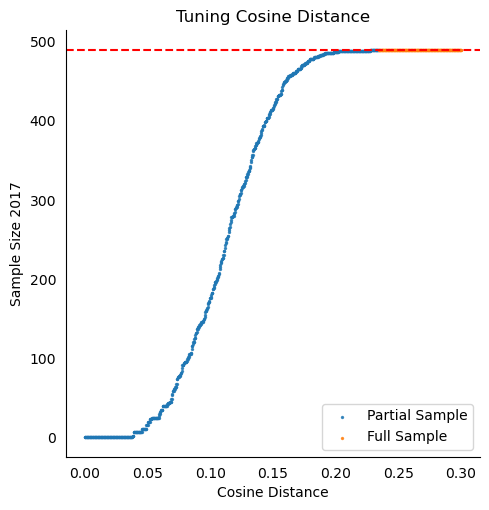

Smallest Cosine Distance:  0.23453453453453452
----------------------------------------------------------------------------------------------------
Table 3
2017 title:  Machine Comprehension Using Match-LSTM and Answer Pointer |


2018 title: QANet: Combining Local Convolution with Global Self-Attention for Reading Comprehension | cosine distance 0.104
2018 title: Multi-Mention Learning for Reading Comprehension with Neural Cascades | cosine distance 0.11
2018 title: LEARNING TO ORGANIZE KNOWLEDGE WITH N-GRAM MACHINES | cosine distance 0.129
2018 title: FAST READING COMPREHENSION WITH CONVNETS | cosine distance 0.131
2018 title: ElimiNet: A Model for Eliminating Options for Reading Comprehension with Multiple Choice Questions | cosine distance 0.133
2018 title: FusionNet: Fusing via Fully-aware Attention with Application to Machine Comprehension | cosine distance 0.133
2018 title: Dynamic Integration of Background Knowledge in Neural NLU Systems | cosine distance 0.139
2018 title: Neur

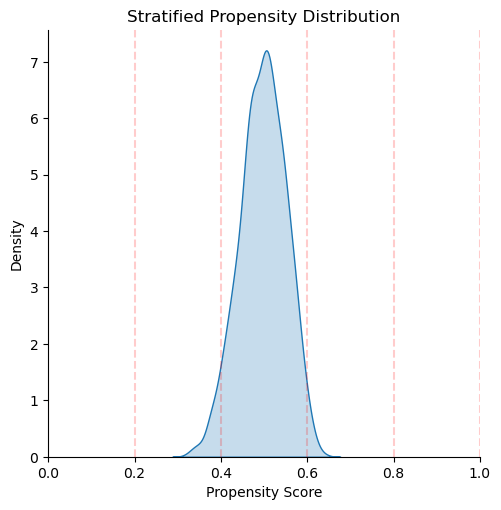

----------------------------------------------------------------------------------------------------
Table 8
kappa 0.562126403742096
fleiss 0.5621745331520116
alpha 0.5626537528124671
scotts 0.5621672720035822


In [11]:
print('Table 1')
print(df_performance)
print('T-Test: naive vs KNN:',stats.ttest_rel(lst_naive, lst_KNN))
print('T-Test: SPSM vs KNN:',stats.ttest_rel(lst_spsm, lst_KNN))
print('-'*100)
print('Table 2')
print("Embedding Matching ATT: ", round(KNN_ATT,2))
print('95% confidence interval: ',round(CI_lower_bound_knn,2),round(CI_upper_bound_knn,2) )
print('range of CI: ',round(CI_knn_range,2))

print("Naive ATT: ", round(naive_mean,2))
print('95% confidence interval: ',round(CI_lower_bound_naive,2),round(CI_upper_bound_naive,2))
print('range of CI: ',round(CI_naive_range,2))

print("Bootstrap SPSM ATT: ", round(-SPSM_mean,2))
print('95% confidence interval: ',round(-np.nanquantile(boostrap_SPSM, 0.975),2),round(-np.nanquantile(boostrap_SPSM, 0.025),2) )
print('range of CI: ',round(abs(np.nanquantile(boostrap_SPSM, 0.975)),2)-round(abs(np.nanquantile(boostrap_SPSM, 0.025)),2))
print('-'*100)

print('Figure 2')
data = []
for tuning_param_cos_dist in np.linspace(0,0.3 ,1000):
    input_row = {}
    sample_number_from_2017 = df_tuning[df_tuning<=tuning_param_cos_dist].any(axis=1).sum()
    
    input_row['sample_number_2017'] = sample_number_from_2017
    input_row['cosine_distance'] = tuning_param_cos_dist
    if sample_number_from_2017 == df_tuning.shape[0]:
        input_row['full_sample_flag'] = 'Full Sample'
    else:
        input_row['full_sample_flag'] = 'Partial Sample'
    data.append(input_row)


x = pd.DataFrame(data)   


# Use the 'hue' argument to provide a factor variable
sns.lmplot( x="cosine_distance", y="sample_number_2017" ,data=x, 
           fit_reg=False, 
           hue='full_sample_flag', 
           #palette = 'flare',
           legend=False,scatter_kws={"s": 2})
# Move the legend to an empty part of the plot
plt.legend(loc='lower right')
plt.axhline(y = df_tuning.shape[0], color = 'r', linestyle = 'dashed')
plt.xlabel('Cosine Distance')
plt.ylabel('Sample Size 2017')
plt.title('Tuning Cosine Distance')
plt.tick_params(left=False, bottom=False) 
plt.show()
print('Smallest Cosine Distance: ',x[x['sample_number_2017']==490].cosine_distance.iloc[:1].values[0])
print('-'*100)


print('Table 3')
#Table 3 in Appendix
first_row = df_embeddings_2017[['title','keywords','agg_cluster','titles_2018','cos_dist_2018','keywords_2018']].iloc[1]
print('2017 title: ',first_row.title,'|')
print('\n')
for title, keywords_2018, cos_dist_2018 in zip(first_row.titles_2018,first_row.keywords_2018, first_row.cos_dist_2018):
    print("2018 title:",title, '| cosine distance',round(cos_dist_2018,3) )
print('-'*100)

print('Table 4')
print(pd.DataFrame(list(itertools.chain.from_iterable(df_embeddings_2017.titles_2018.to_list())),columns=['paper_id']).value_counts().head())
print('-'*100)

print('Table 5')
print('Best Parameters:',t_model_gridsearch.best_params_)
print("Run Time:", str(total_time))
print('-'*100)

print('Table 6')
pprint.pprint(pred_model_report_out)
print('-'*100)

print('Table 7')
print(df_paper_strata[['paper_id','strata','treatment']].groupby(['strata','treatment']).count())
print('-'*100)


print('Figure 3')
sns.displot(df_paper_strata,x='pscore',kind='kde',fill=True)
plt.xlim(0,1)
plt.axvline(0., alpha=0.2,color='r')
plt.axvline(0.2, alpha=0.2,color='r', linestyle = 'dashed')
plt.axvline(0.4, alpha=0.2,color='r', linestyle = 'dashed')
plt.axvline(0.6, alpha=0.2,color='r', linestyle = 'dashed')
plt.axvline(0.8, alpha=0.2,color='r', linestyle = 'dashed')
plt.axvline(1., alpha=0.2,color='r', linestyle = 'dashed')
plt.xlabel('Propensity Score')
plt.title('Stratified Propensity Distribution')
plt.show()
print('-'*100)

print('Table 8')
print("kappa " +str(ratingtask.kappa()))
print("fleiss " + str(ratingtask.multi_kappa()))
print("alpha " +str(ratingtask.alpha()))
print("scotts " + str(ratingtask.pi()))